### This Workbook will develop an optimised Equity Portfolio through maximisation of Portfolio's Sharpe Ratio 

#### Limitations of mean-variance analysis

This workbook utilises Markowitz Modern Portfolio Theory (Mean-variance analysis) to calculate weights for each listed equity security included in a portfolio, and to maximise portfolio's Sharpe Ratio. It is relevant to discuss some practical limitations of this approach, as follows:

1.  Mean-variance analysis uses arithmetic mean to estimate expected returns. Given that future negative return periods are likely, arithmetic mean will be higher than its geometric equivalent, and may overstate expected returns.<br>

2.  Continuing from previous point, the assumption of a normal distribution of returns is a major practical limitation. Normal distribution is symmetrical; using variance to measure risk implies that uncertainty about better-than-expected returns is equal to uncertainty about returns that are worse-than-expected. In practice, this makes modeled investment returns with more upside than downside appear more risky than they really are. <br>  

3.  MPT doesn't model downside risk. During periods of extreme market stress, cross-asset correlations increase markedly and temporarily diverge from long-term levels, which leads to underestimation of probability of **joint negative returns**. MPT attempts to model risk in terms of the likelihood of losses, but says nothing about why those losses might occur. The risk measurements used are therefore probabilistic in nature, not structural. Although MPT framework may allow investors to diversify away unsystematic risks, __systematic risks do not eliminate__.<br>

4.  Using **only** long-term historical averages in portfolio construction may be a flawed approach if future results are dramatically different from the long-term historical data due to indexing and passive flow effects, ESG mandates, or risk-on/risk-off market effects. 

Mean-variance optimisation should be attempted over multiple time horizons to account for future changes in market regimes (liquidity, economic conditions, earnings cycles etc.).<br>

Put simply, MPT framework is a useful tool for developing a diversified Equity Portfolio, however, it is not a set-and-forget solution. Investors should apply reasonable weight constraints, conduct sensitivity analysis and rebalance holdings when required. Individual security analysis and selection, and consideration of prevalent market regime/conditions are core tenets of active Portfolio Management.  

#### Import Libraries

In [40]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd

import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline
import seaborn as sns # Plotting

import plotly.express as px
import plotly.graph_objects as go

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance
import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#### Constants

In [32]:
# Define path to files
PATH = (r"C:/Users/User/Documents/PM Tools/US Share Market Data/Wilshire5000/")
t_days = 252 # average number of trading days in a year

S_YEAR = 2013
S_MONTH = 1
S_DAY = 1
S_DATE_STR = f"{S_YEAR}-{S_MONTH}-{S_DAY}" #string representation of start date
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY) #datetime object representation of start date

E_YEAR = 2022
E_MONTH = 12
E_DAY = 31
E_DATE_STR = f"{E_YEAR}-{E_MONTH}-{E_DAY}" #string representation of end date
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY) #datetime object representation of end date

risk_free_rate = 0.0152 # 10 year UST yield at the end of 2021 as risk free proxy

#### Get Share Ticker Names and place in List

In [3]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]  
# listdir retuns all files in a directory (PATH). 
# isfile returns TRUE if file, and store in list []
tickers = [os.path.splitext(x)[0] for x in files] 
# splitext splits the path name into a pair root and ext.; ticker name and extension(.csv). 
# Index [0] points to root.
# Get all file names and store in "tickers".
tickers

['A',
 'AA',
 'AAC',
 'AAL',
 'AAME',
 'AAN',
 'AAOI',
 'AAON',
 'AAP',
 'AAPL',
 'AAT',
 'AAWW',
 'ABBV',
 'ABC',
 'ABCB',
 'ABEO',
 'ABG',
 'ABIO',
 'ABM',
 'ABMD',
 'ABR',
 'ABT',
 'ABTX',
 'AC',
 'ACA',
 'ACAD',
 'ACBI',
 'ACC',
 'ACCO',
 'ACER',
 'ACGL',
 'ACHC',
 'ACHN',
 'ACHV',
 'ACIA',
 'ACIW',
 'ACLS',
 'ACM',
 'ACMR',
 'ACN',
 'ACNB',
 'ACOR',
 'ACRE',
 'ACRS',
 'ACRX',
 'ACTG',
 'ACU',
 'ADBE',
 'ADC',
 'ADES',
 'ADI',
 'ADM',
 'ADMA',
 'ADMP',
 'ADMS',
 'ADNT',
 'ADP',
 'ADSK',
 'ADT',
 'ADTN',
 'ADUS',
 'ADVM',
 'ADXS',
 'AE',
 'AEE',
 'AEGN',
 'AEHR',
 'AEIS',
 'AEL',
 'AEMD',
 'AEO',
 'AEP',
 'AERI',
 'AES',
 'AEY',
 'AFG',
 'AFL',
 'AGCO',
 'AGE',
 'AGEN',
 'AGFS',
 'AGIO',
 'AGLE',
 'AGM',
 'AGNC',
 'AGO',
 'AGR',
 'AGRX',
 'AGS',
 'AGTC',
 'AGX',
 'AGYS',
 'AHH',
 'AHT',
 'AIG',
 'AIMC',
 'AIMT',
 'AIN',
 'AINC',
 'AIR',
 'AIRG',
 'AIRI',
 'AIRT',
 'AIT',
 'AIV',
 'AIZ',
 'AJG',
 'AJRD',
 'AJX',
 'AKAM',
 'AKBA',
 'AKCA',
 'AKR',
 'AKTS',
 'AL',
 'ALB',
 'ALBO',
 'AL

#### Return Dataframe from a CSV file

In [4]:
def get_df_from_csv(ticker):
    try:
        # read csv and select the date column as index
        df = pd.read_csv(PATH + ticker + '.csv', index_col='date', parse_dates=True)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df

#### Merge Multiple Shares by Column Name

In [5]:
# merge shares by common column name and return dataframe
def merge_df_by_column_name(column_name, sdate, edate, *tickers):
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        # use a mask to get data between defined dates
        # date column was set to index in previous function
        mask = (df.index >= sdate) & (df.index <= edate) 
        mult_df[x] = df.loc[mask][column_name]
        
    return mult_df

#### Markowitz Portfolio Optimisation

Modern portfolio theory (MPT), or mean-variance analysis, is a mathematical framework for developing a portfolio of assets where the expected return is maximized for a given level of risk. Key insight of MPT is that an asset's risk and return should not only be assessed by itself, but by how it contributes to a portfolio's overall risk and return. It uses the variance of asset prices as a proxy for risk.

We do this by creating equity portfolios with __uncorrelated__ investments. We want to calculate portfolio expected returns ($r_{p}$) by analysing the returns ($r$) of each security multiplied by its weight ($w$).

$ r_{p} = w_ar_a + w_br_b$


Portfolio Return volatility (standard deviation) for a two asset portfolio is calculated as per the bellow formula; where, $\rho$ is the correlation coefficient between two assets, $r$ represents asset returns, $w$ represents individual weights, and $\sigma^2$ is the variance or squared standard deviation for each security. 

$\sigma_{p}^2$ = $(w_a\sigma_a + w_b\sigma_b)^2 = w_a^2\sigma_a^2 + w_b^2\sigma_b^2 + 2w_a\sigma_aw_b\sigma_b\rho_{ab} $<br>

Portfolio Return volatility $(\sigma_{p})$ = $\sqrt{\sigma_{p}^2}$

Matrices are preferred for calculations. For a multi security portfolio:

Portfolio Return Volatility ($\sigma_{p}$) = $\sqrt{{\sum}{w_{T}}{w}}$

Where:<br>
$w_{T}$:&emsp;Transposed portfolio weights<br>
${w}$:&emsp;&nbsp;&ensp;Portfolio weights<br>
$\sum$:&emsp;&ensp;Covariance matrix of returns<br>

#### List of Portfolio Securities

Criteria for individual security selection is outside the scope of this Workbook. 

In [7]:
# list of portfolio securities
portfolio_list = ["MSFT", "WMT", "UNH", "JNJ", "XOM", "JPM", "PG", "TMO", "DHR", "VZ",
                  "PM", "HON", "CAT", "CVS", "MCK", "CDNS", "WMB", "DD", "K"]

#### Merge all share price data

In [8]:
# merge data by "Adj. Close" Share Price column
mult_df = merge_df_by_column_name('Adj. Close', '2017-01-03', '2021-12-31', *portfolio_list) 
mult_df   

,MSFT,WMT,UNH,JNJ,XOM,JPM,PG,TMO,DHR,VZ,PM,HON,CAT,CVS,MCK,CDNS,WMB,DD,K
date,,,,,,,,,,,,,,,,,,,
2021-12-31,333.159988,142.453871,495.741599,166.701768,58.872097,153.452444,159.606834,665.772487,328.088568,49.255817,90.075406,204.324700,202.025944,100.866457,247.077885,186.35,24.747926,79.240124,62.301049
2021-12-30,336.131800,140.957362,498.002419,167.910105,58.487249,153.578423,158.816508,663.986424,327.550081,49.530725,89.373766,202.952801,201.380993,101.374896,247.405904,188.25,24.633881,78.602514,61.827166
2021-12-29,338.737089,140.504471,499.137766,167.169511,58.833612,153.655949,160.202018,661.272407,325.665374,49.635000,89.411692,203.364371,202.602491,101.394451,246.968546,189.93,24.747926,79.053746,61.788482
2021-12-28,338.043666,140.573389,496.531405,166.000153,59.353156,153.733475,158.884808,653.938572,322.326903,49.976264,88.994501,202.894006,201.908680,100.485128,245.010371,190.08,24.861972,78.916414,61.846508
2021-12-27,339.232391,138.584607,493.135239,165.337517,59.545580,153.268321,158.035939,660.753550,326.283240,49.938346,88.691089,202.286451,201.674153,100.123354,243.867274,191.65,24.957010,78.288614,61.179204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-09,57.693367,61.129812,148.347778,99.301959,64.452189,73.293105,71.379514,145.211239,78.406890,40.376710,66.329775,99.808789,79.297263,69.188278,138.750837,25.72,22.360730,137.230026,58.627645
2017-01-06,57.877573,60.729456,148.769143,99.319039,65.533303,73.242077,71.912323,144.994638,78.251224,40.821252,66.714780,100.640882,79.872441,69.611707,138.826430,25.65,22.703880,136.597115,59.440451
2017-01-05,57.380217,61.574651,148.558460,99.797273,65.570328,73.233573,71.937695,143.133839,77.842602,41.429732,66.199019,99.138019,79.838102,68.951158,138.429567,25.66,22.227673,137.397561,59.424195


#### Growth of Portfolio Investments over the selected range

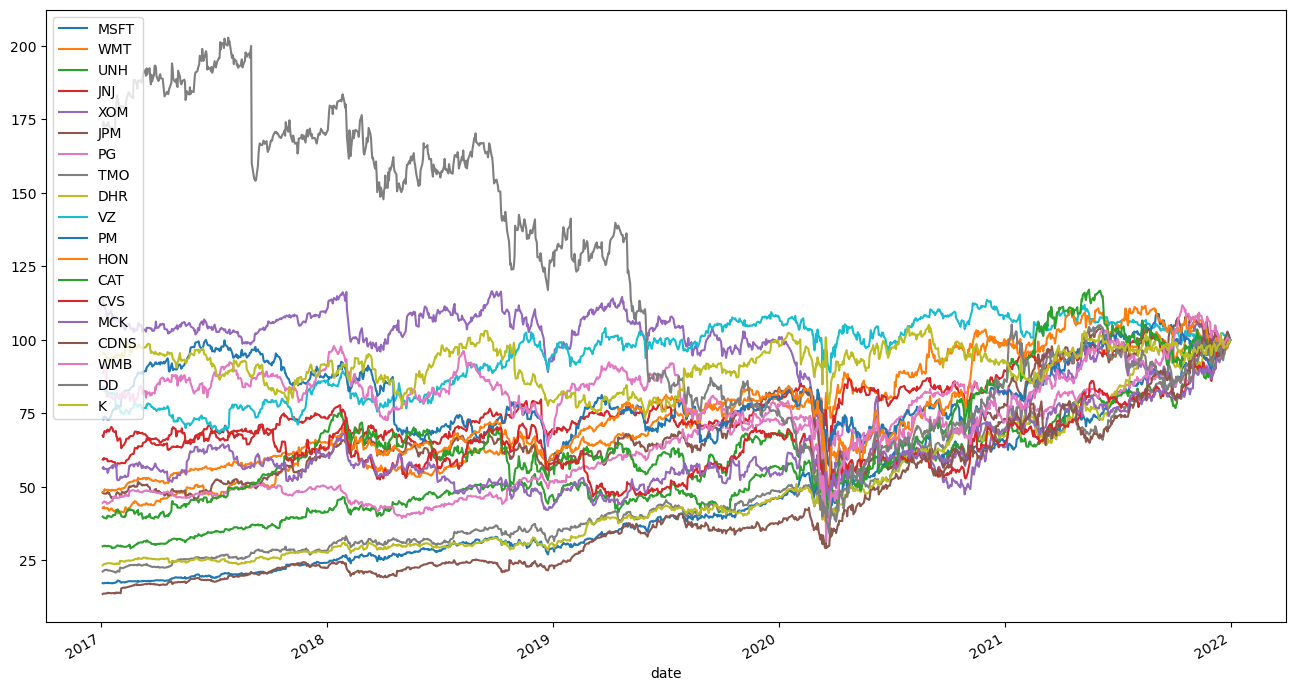

In [11]:
(mult_df / mult_df.iloc[0] * 100).plot(figsize=(16, 9));

In [44]:
# plot out prices for each investment since beginning of 2017
fig = px.line(mult_df, x=mult_df.index, y=mult_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price in USD")
fig.update_layout(height=667, width=1000, 
                  showlegend=True)
fig.show()

#### Calculate Mean Returns

In [12]:
# calculate daily returns matrix for portfolio securities
returns = mult_df / mult_df.shift(-1) - 1
returns 

,MSFT,WMT,UNH,JNJ,XOM,JPM,PG,TMO,DHR,VZ,PM,HON,CAT,CVS,MCK,CDNS,WMB,DD,K
date,,,,,,,,,,,,,,,,,,,
2021-12-31,-0.008841,0.010617,-0.004540,-0.007196,0.006580,-0.000820,0.004976,0.002690,0.001644,-0.005550,0.007851,0.006760,0.003203,-0.005015,-0.001326,-0.010093,0.004630,0.008112,0.007665
2021-12-30,-0.007691,0.003223,-0.002275,0.004430,-0.005887,-0.000505,-0.008649,0.004104,0.005787,-0.002101,-0.000424,-0.002024,-0.006029,-0.000193,0.001771,-0.008845,-0.004608,-0.005708,0.000626
2021-12-29,0.002051,-0.000490,0.005249,0.007044,-0.008753,-0.000504,0.008290,0.011215,0.010357,-0.006829,0.004688,0.002318,0.003436,0.009049,0.007992,-0.000789,-0.004587,0.001740,-0.000938
2021-12-28,-0.003504,0.014351,0.006887,0.004008,-0.003232,0.003035,0.005371,-0.010314,-0.012125,0.000759,0.003421,0.003003,0.001163,0.003613,0.004687,-0.008192,-0.003808,0.008019,0.010907
2021-12-27,0.023186,0.009105,0.008317,0.008440,0.014258,0.005723,0.011680,0.017689,0.020637,0.000000,0.006564,0.005896,0.000873,0.010759,0.018938,0.022242,0.015861,0.016170,0.006203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-09,-0.003183,0.006592,-0.002832,-0.000172,-0.016497,0.000697,-0.007409,0.001494,0.001989,-0.010890,-0.005771,-0.008268,-0.007201,-0.006083,-0.000545,0.002729,-0.015114,0.004633,-0.013674
2017-01-06,0.008668,-0.013726,0.001418,-0.004792,-0.000565,0.000116,-0.000353,0.013000,0.005249,-0.014687,0.007791,0.015159,0.000430,0.009580,0.002867,-0.000390,0.021424,-0.005826,0.000274
2017-01-05,0.000000,0.002172,0.001668,0.010463,-0.014907,-0.009205,0.006627,0.001516,0.009208,0.002201,0.007852,0.002232,-0.006092,0.020940,-0.013999,0.003520,0.012117,-0.004854,-0.000957


In [13]:
# get mean annual return for each security
mean_returns = returns.mean() * t_days # t_days: 252 average trading days per year
mean_returns

MSFT    0.389476
WMT     0.193331
UNH     0.283007
JNJ     0.124692
XOM     0.019301
JPM     0.191769
PG      0.181893
TMO     0.343080
DHR     0.318521
VZ      0.052382
PM      0.095996
HON     0.177772
CAT     0.232871
CVS     0.118810
MCK     0.161480
CDNS    0.452720
WMB     0.085153
DD     -0.047843
K       0.035694
dtype: float64

#### Portfolio Covariance Matrix

In [14]:
# get covariance matrix for portfolio securities
returns.cov()

,MSFT,WMT,UNH,JNJ,XOM,JPM,PG,TMO,DHR,VZ,PM,HON,CAT,CVS,MCK,CDNS,WMB,DD,K
MSFT,0.000300,0.000098,0.000173,0.000108,0.000124,0.000159,0.000103,0.000163,0.000153,0.000067,0.000109,0.000149,0.000155,0.000114,0.000135,0.000252,0.000143,0.000167,0.000065
WMT,0.000098,0.000189,0.000084,0.000072,0.000058,0.000072,0.000088,0.000074,0.000068,0.000064,0.000071,0.000059,0.000077,0.000101,0.000089,0.000086,0.000038,0.000072,0.000073
UNH,0.000173,0.000084,0.000321,0.000118,0.000150,0.000174,0.000098,0.000132,0.000133,0.000084,0.000130,0.000160,0.000155,0.000175,0.000166,0.000166,0.000155,0.000168,0.000075
JNJ,0.000108,0.000072,0.000118,0.000159,0.000092,0.000103,0.000093,0.000100,0.000094,0.000072,0.000092,0.000099,0.000103,0.000105,0.000118,0.000097,0.000067,0.000108,0.000074
XOM,0.000124,0.000058,0.000150,0.000092,0.000366,0.000243,0.000076,0.000065,0.000073,0.000079,0.000138,0.000194,0.000232,0.000136,0.000144,0.000116,0.000269,0.000229,0.000051
JPM,0.000159,0.000072,0.000174,0.000103,0.000243,0.000359,0.000089,0.000098,0.000104,0.000091,0.000142,0.000222,0.000246,0.000157,0.000167,0.000140,0.000247,0.000261,0.000060
PG,0.000103,0.000088,0.000098,0.000093,0.000076,0.000089,0.000161,0.000085,0.000086,0.000079,0.000103,0.000085,0.000086,0.000091,0.000098,0.000091,0.000067,0.000086,0.000100
TMO,0.000163,0.000074,0.000132,0.000100,0.000065,0.000098,0.000085,0.000259,0.000177,0.000056,0.000071,0.000110,0.000119,0.000095,0.000115,0.000178,0.000078,0.000131,0.000062
DHR,0.000153,0.000068,0.000133,0.000094,0.000073,0.000104,0.000086,0.000177,0.000215,0.000059,0.000083,0.000110,0.000109,0.000092,0.000105,0.000166,0.000100,0.000119,0.000058
VZ,0.000067,0.000064,0.000084,0.000072,0.000079,0.000091,0.000079,0.000056,0.000059,0.000139,0.000080,0.000073,0.000079,0.000092,0.000083,0.000059,0.000066,0.000074,0.000068


#### Portfolio Correlation Matrix

Portfolio should contain a mix of __uncorrelated__ securities. Ideally, correlation coefficients should be under 0.5.

In [15]:
# get correlation matrix for portfolio securities
returns.corr()

,MSFT,WMT,UNH,JNJ,XOM,JPM,PG,TMO,DHR,VZ,PM,HON,CAT,CVS,MCK,CDNS,WMB,DD,K
MSFT,1.000000,0.411023,0.558086,0.493506,0.375558,0.484552,0.467579,0.584478,0.602371,0.328692,0.382853,0.539499,0.454683,0.370725,0.403060,0.709542,0.374574,0.440239,0.257423
WMT,0.411023,1.000000,0.340574,0.414043,0.221791,0.275329,0.503823,0.335554,0.337127,0.393770,0.314425,0.271197,0.285569,0.412217,0.333814,0.304694,0.125918,0.236919,0.362957
UNH,0.558086,0.340574,1.000000,0.522344,0.436533,0.512652,0.432888,0.457372,0.504642,0.399058,0.442130,0.561372,0.440283,0.547680,0.479879,0.450382,0.391317,0.426701,0.285056
JNJ,0.493506,0.414043,0.522344,1.000000,0.381024,0.429112,0.581458,0.491064,0.507824,0.483101,0.445835,0.494285,0.414074,0.466645,0.486123,0.373583,0.239909,0.389133,0.403121
XOM,0.375558,0.221791,0.436533,0.381024,1.000000,0.670164,0.313370,0.209929,0.260366,0.349528,0.438212,0.638387,0.616557,0.399309,0.391028,0.296119,0.638738,0.545811,0.182829
JPM,0.484552,0.275329,0.512652,0.429112,0.670164,1.000000,0.371276,0.322696,0.372881,0.405682,0.458105,0.738156,0.662051,0.466663,0.457792,0.359715,0.592552,0.628325,0.217005
PG,0.467579,0.503823,0.432888,0.581458,0.313370,0.371276,1.000000,0.418579,0.461310,0.527923,0.494176,0.420938,0.346625,0.404987,0.402818,0.350155,0.238371,0.309246,0.537618
TMO,0.584478,0.335554,0.457372,0.491064,0.209929,0.322696,0.418579,1.000000,0.748770,0.296917,0.268602,0.430874,0.376009,0.333452,0.371693,0.538297,0.219542,0.369384,0.265666
DHR,0.602371,0.337127,0.504642,0.507824,0.260366,0.372881,0.461310,0.748770,1.000000,0.339102,0.345583,0.469602,0.379543,0.351006,0.369761,0.552450,0.308771,0.368626,0.268825
VZ,0.328692,0.393770,0.399058,0.483101,0.349528,0.405682,0.527923,0.296917,0.339102,1.000000,0.411248,0.386197,0.340982,0.436835,0.365691,0.243954,0.252458,0.284357,0.395531


#### Generate Random Weights Equal to 1

In [114]:
# number of securities in a portfolio
len(portfolio_list)

19

In [16]:
# generate 19 random weights that sum to 1
weights = np.random.random(19) # generate 19 random values
weights = weights / np.sum(weights) # divide each random value by the sum of random values to get individual weights 
print('Weights:', weights)
print('Check Sum:', np.sum(weights))

Weights: [0.02756382 0.10498906 0.07871562 0.05941989 0.03252543 0.00356855
 0.07956839 0.05623705 0.04164124 0.10756843 0.0862323  0.02861515
 0.03669424 0.00533426 0.0391478  0.03981372 0.0788669  0.07958667
 0.01391147]
Check Sum: 1.0


#### Calculating Portfolio Return

In [27]:
# portfolio annualised expected return using random weights
np.sum(weights * returns.mean()) * 252

0.16499080268920865

#### Calculating Portfolio Volatility

Portfolio Return Volatility ($\sigma_{p}$) = $\sqrt{{\sum}{w_{T}}{w}}$

Where:<br>
$w_{T}$:&emsp;Transposed portfolio weights<br>
${w}$:&emsp;&nbsp;&ensp;Portfolio weights<br>
$\sum$:&emsp;&ensp;Covariance matrix of returns<br>

In [31]:
# get portfolio expected standard deviation using random weights
# transpose of a numpy array can be calculated using the .T attribute 
# np.dot() function is the dot-product of two arrays
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

0.17254288023473785

#### Risk&Return Profile for 100,000 Random Portfolio Combinations

Here we generate 100,000 portfolios with random weights for securities in our portfolio list. For each portfolio combination, function will output lists for returns, volatility (standard deviation), Sharpe Ratio and individual security weights. 

**Sharpe Ratio** describes excess returns over the risk free rate in relation to the asset's volatility (standard deviation). Largest Sharpe Ratio describes the asset or portfolio that provides the __best return for the lowest amount of risk__.

Sharpe Ratio = $\frac{r_i - r_f}{\sigma_i}$<br>

$r_f$ = Risk Free Rate<br>
$r_i$ = Securities Rate of Return<br>
$\sigma_i$ = Securities Standard Deviation<br>



In [33]:
p_ret = [] # List of Returns for 100,000 portfolios 
p_wt = [] # Share weights list -//-
p_vol = [] # Volatility list -//-
p_SR = [] # Sharpe Ratio list -//-

for x in range(100000):
    # generate random weights
    p_weights = np.random.random(19) # generate 19 random values
    p_weights /= np.sum(p_weights) # divide each random value by the sum of random values to get individual weights 
    
    # add annualised return using random weights and append list
    ret_x = np.sum(p_weights * returns.mean()) * 252 # average 252 trading days in a year
    p_ret.append(ret_x)
    
    # add volatility / standard deviation and append list
    vol_x = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
    p_vol.append(vol_x)
    
    # get Sharpe ratio and append list
    SR_x = (ret_x - risk_free_rate) / vol_x
    p_SR.append(SR_x)
    
    # get securities weights for each portfolio and append list
    p_wt.append(p_weights)
    
    # convert updated lists to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

(array([0.17734079, 0.18619359, 0.19092817, ..., 0.15493236, 0.18871337,
        0.20978334]),
 array([0.17805715, 0.18167044, 0.17900126, ..., 0.18319594, 0.17667305,
        0.17630527]),
 array([0.91061093, 0.94122956, 0.98171474, ..., 0.76274815, 0.98211567,
        1.10367282]),
 array([[0.05172192, 0.01194257, 0.05751199, ..., 0.09279257, 0.02477222,
         0.05244655],
        [0.07952285, 0.05979563, 0.01796166, ..., 0.02322385, 0.07883395,
         0.03312215],
        [0.05873891, 0.05116473, 0.05916764, ..., 0.04137937, 0.04450901,
         0.09484019],
        ...,
        [0.02087622, 0.05549248, 0.02798701, ..., 0.08387744, 0.04896407,
         0.09066512],
        [0.01773692, 0.02072898, 0.08754882, ..., 0.02401982, 0.06070041,
         0.04630406],
        [0.07865411, 0.05812295, 0.00059902, ..., 0.01761622, 0.01895848,
         0.04554934]]))

#### Plot portfolio combinations and find security weights

Here, we are discovering a Portfolio that generates the highest level of return at any point along the risk curve.

In [34]:
# dataframe with returns and volatility (standard deviation)
portfolios = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})
portfolios


,Return,Volatility
0,0.177341,0.178057
1,0.186194,0.181670
2,0.190928,0.179001
3,0.179664,0.177573
4,0.188643,0.186229
...,...,...
99995,0.189257,0.185782
99996,0.186703,0.177837
99997,0.154932,0.183196
99998,0.188713,0.176673


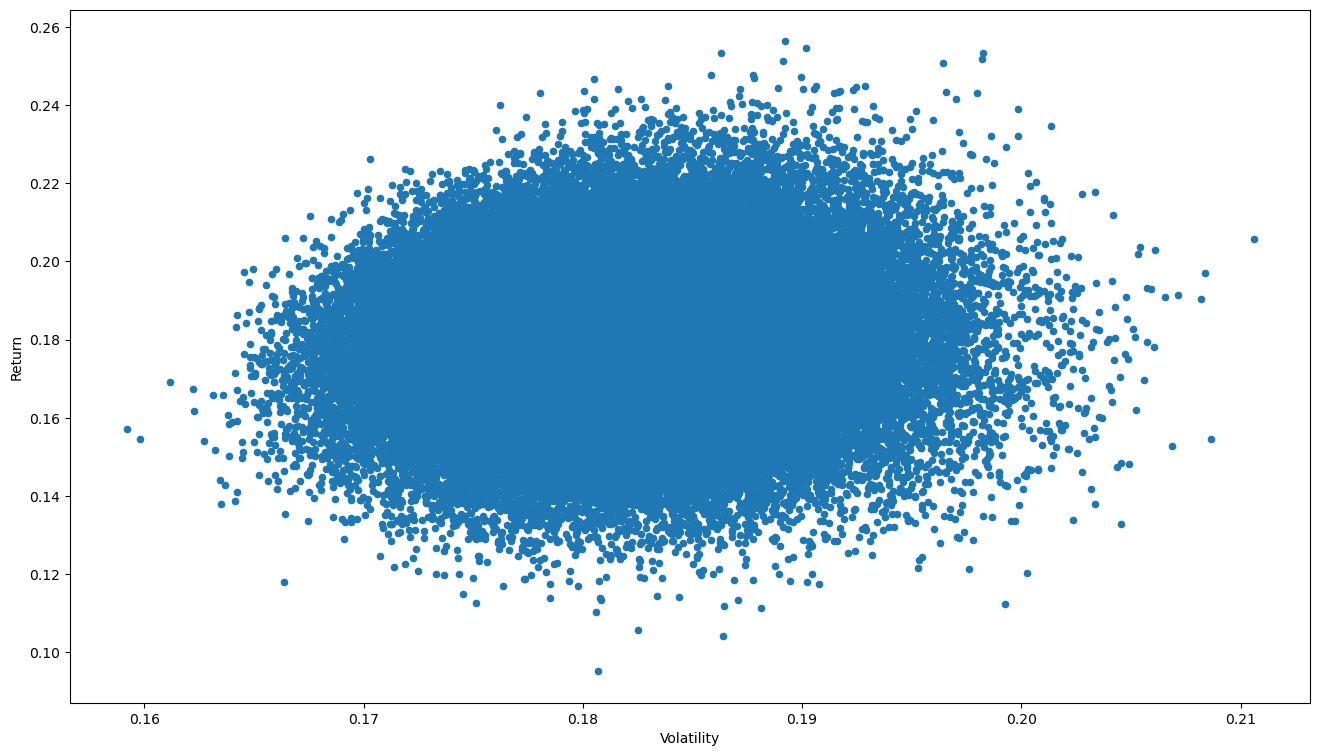

In [35]:
# scatter plot 100,000 portfolio risk and return combinations
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(16, 9));

In [37]:
# Return index with the largest Sharpe Ratio
SR_index = np.argmax(p_SR)

# portfolio weights at that index
print("Portfolio with the largest Sharpe Ratio has the following weights:")
i = 0
while i < 19:
    
    print("Stock : %s : %2.2f" % (portfolio_list[i], (p_wt[SR_index][i] * 100)), "%")
    i += 1
    
print("Portfolio Expected Risk and Return:")    
# volatility of that portfolio
print("\nVolatility :", p_vol[SR_index] * 100, "%")
# expected return of that portfolio
print("Expected Return :", p_ret[SR_index] * 100, "%")

Portfolio with the largest Sharpe Ratio has the following weights:
Stock : MSFT : 12.60 %
Stock : WMT : 10.32 %
Stock : UNH : 11.25 %
Stock : JNJ : 9.68 %
Stock : XOM : 0.79 %
Stock : JPM : 1.70 %
Stock : PG : 10.45 %
Stock : TMO : 6.63 %
Stock : DHR : 3.46 %
Stock : VZ : 3.37 %
Stock : PM : 2.79 %
Stock : HON : 2.83 %
Stock : CAT : 0.09 %
Stock : CVS : 4.33 %
Stock : MCK : 3.28 %
Stock : CDNS : 11.93 %
Stock : WMB : 4.03 %
Stock : DD : 0.36 %
Stock : K : 0.10 %
Portfolio Expected Risk and Return:

Volatility : 18.04925543545642 %
Expected Return : 24.65781576162875 %
